In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install wfdb
!pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 13.0 MB/s eta 0:00:00a 0:00:01


Epoch 1/30 | Loss=0.4666 | Acc=0.8134 | F1=0.7293


Epoch 2/30 | Loss=0.3297 | Acc=0.7833 | F1=0.7261


Epoch 3/30 | Loss=0.2944 | Acc=0.8215 | F1=0.7638


Epoch 4/30 | Loss=0.2604 | Acc=0.8342 | F1=0.7791


Epoch 5/30 | Loss=0.2503 | Acc=0.8340 | F1=0.7783


Epoch 6/30 | Loss=0.2255 | Acc=0.8196 | F1=0.7771


Epoch 7/30 | Loss=0.2177 | Acc=0.8256 | F1=0.7826


Epoch 8/30 | Loss=0.2171 | Acc=0.8456 | F1=0.7749


Epoch 9/30 | Loss=0.2234 | Acc=0.8088 | F1=0.6941


Epoch 10/30 | Loss=0.2366 | Acc=0.8473 | F1=0.7967


Epoch 11/30 | Loss=0.1901 | Acc=0.8351 | F1=0.7833


Epoch 12/30 | Loss=0.1712 | Acc=0.8443 | F1=0.7815


Epoch 13/30 | Loss=0.1620 | Acc=0.8428 | F1=0.7909


Epoch 14/30 | Loss=0.1526 | Acc=0.8504 | F1=0.7930


Epoch 15/30 | Loss=0.1467 | Acc=0.8353 | F1=0.7563


Epoch 16/30 | Loss=0.1326 | Acc=0.8341 | F1=0.7515


Epoch 17/30 | Loss=0.1548 | Acc=0.8485 | F1=0.7881


Epoch 18/30 | Loss=0.2221 | Acc=0.8393 | F1=0.7732


Epoch 19/30 | Loss=0.1419 | Acc=0.8262 | F1=0.7538


Epoch 20/30 | Loss=0.1193 | Acc=0.8457 | F1=0.7906


Epoch 21/30 | Loss=0.1085 | Acc=0.8321 | F1=0.7500


Epoch 22/30 | Loss=0.0966 | Acc=0.8352 | F1=0.7672


Epoch 23/30 | Loss=0.0934 | Acc=0.8277 | F1=0.7789


Epoch 24/30 | Loss=0.0827 | Acc=0.8335 | F1=0.7861


Epoch 25/30 | Loss=0.0780 | Acc=0.8400 | F1=0.7936


Epoch 26/30 | Loss=0.0763 | Acc=0.8419 | F1=0.7683


Epoch 27/30 | Loss=0.0830 | Acc=0.8408 | F1=0.7869


Epoch 28/30 | Loss=0.0661 | Acc=0.8355 | F1=0.7582


Epoch 29/30 | Loss=0.0724 | Acc=0.8352 | F1=0.7906


Epoch 30/30 | Loss=0.0566 | Acc=0.8404 | F1=0.7872

=== Final Test Performance ===
Accuracy=0.8504
F1-score=0.7930
              precision    recall  f1-score   support

   Non-Apnea       0.86      0.91      0.88     10591
       Apnea       0.84      0.75      0.79      6517

    accuracy                           0.85     17108
   macro avg       0.85      0.83      0.84     17108
weighted avg       0.85      0.85      0.85     17108



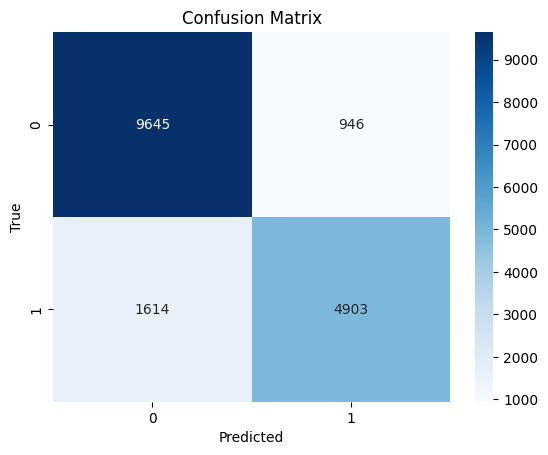

In [5]:
# ---------------------- Imports ----------------------
import os
import random
import numpy as np
import pandas as pd
import wfdb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from scipy.signal import butter, filtfilt, medfilt, find_peaks
from scipy.stats import mstats
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# ---------------------- Config ----------------------
DATASET_PATH = "/kaggle/input/apnea-new-dataset/apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0"
ORIG_FS = 100
WIN_MIN, STRIDE_MIN = 5, 1
WIN_SIZE = ORIG_FS * 60 * WIN_MIN
STEP = ORIG_FS * 60 * STRIDE_MIN
SEQ_LEN = 300
BATCH_SIZE = 64
EPOCHS = 30
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

# ---------------------- Preprocessing Pipeline ----------------------
def check_missing_values(sig):
    return np.isnan(sig).any()

def check_flatline(sig, threshold=0.001, fs=100):
    diff = np.abs(np.diff(sig[:,0]))
    return np.sum(diff < threshold) > len(sig) * 0.05

def check_clipping(sig, eps=0.05):
    mx, mn = np.max(sig[:,0]), np.min(sig[:,0])
    return np.sum(sig[:,0] > (mx - eps)) > 10 or np.sum(sig[:,0] < (mn + eps)) > 10

def check_high_noise(sig, fs=100):
    b, a = butter(4, [0.5/(fs/2), 40/(fs/2)], btype='band')
    filtered = filtfilt(b, a, sig[:,0])
    noise_level = np.std(sig[:,0] - filtered)
    return noise_level > np.std(filtered) * 2

def check_baseline_wander(sig, fs=100):
    baseline = medfilt(sig[:,0], kernel_size=501)
    return np.std(baseline) > 0.15

def fix_missing_values(sig):
    for ch in range(sig.shape[1]):
        nans = np.isnan(sig[:, ch])
        if nans.any():
            sig[nans, ch] = np.interp(
                np.flatnonzero(nans),
                np.flatnonzero(~nans),
                sig[~nans, ch]
            )
    return sig

def fix_flatline(sig, threshold=0.001, min_flat_sec=1, fs=100):
    diff = np.abs(np.diff(sig[:,0]))
    flat_mask = diff < threshold
    flat_mask = np.append(flat_mask, False)
    min_samples = min_flat_sec * fs
    cleaned = []
    start = 0
    i = 0
    while i < len(flat_mask):
        if flat_mask[i]:
            j = i
            while j < len(flat_mask) and flat_mask[j]:
                j += 1
            if (j - i) >= min_samples:
                cleaned.append(sig[start:i])
                start = j
            i = j
        else:
            i += 1
    cleaned.append(sig[start:])
    cleaned = np.vstack(cleaned) if len(cleaned) > 1 else sig
    return cleaned

def fix_clipping(sig):
    sig[:,0] = mstats.winsorize(sig[:,0], limits=[0.01, 0.01])
    return sig

def fix_high_noise(sig, fs=100):
    b, a = butter(4, [0.5/(fs/2), 40/(fs/2)], btype='band')
    sig[:,0] = filtfilt(b, a, sig[:,0])
    return sig

def fix_baseline_wander(sig, fs=100):
    b, a = butter(2, 0.5/(fs/2), btype='high')
    sig[:,0] = filtfilt(b, a, sig[:,0])
    sig[:,0] = sig[:,0] - medfilt(sig[:,0], kernel_size=501)
    return sig

def load_record(base_name):
    try:
        rec = wfdb.rdrecord(os.path.join(DATASET_PATH, base_name))
        return rec.p_signal, rec.fs
    except:
        return None, None

def preprocess_one_record(base_name):
    sig, fs = load_record(base_name)
    if sig is None:
        return None, None

    if check_missing_values(sig):
        sig = fix_missing_values(sig)
    if check_flatline(sig, fs=fs):
        sig = fix_flatline(sig, fs=fs)
    if check_baseline_wander(sig, fs=fs):
        sig = fix_baseline_wander(sig, fs=fs)
    if check_high_noise(sig, fs=fs):
        sig = fix_high_noise(sig, fs=fs)
    if check_clipping(sig):
        sig = fix_clipping(sig)

    return sig

# ---------------------- Feature Extraction ----------------------
def extract_features_from_cleaned(sig):
    peaks, _ = find_peaks(sig[:,0], distance=40, height=np.mean(sig[:,0]))
    if len(peaks) < 3:
        return np.zeros((SEQ_LEN, 2), np.float32)
    rri = np.diff(peaks) * 1000 / ORIG_FS
    ra = sig[peaks[:-1],0]
    rri = (rri - np.mean(rri)) / (np.std(rri) + 1e-6)
    ra = (ra - np.mean(ra)) / (np.std(ra) + 1e-6)
    f1 = np.interp(np.linspace(0,len(rri)-1,SEQ_LEN), np.arange(len(rri)), rri)
    f2 = np.interp(np.linspace(0,len(ra)-1,SEQ_LEN), np.arange(len(ra)), ra)
    return np.stack([f1,f2], axis=1).astype(np.float32)

# ---------------------- Dataset ----------------------
class ApneaDataset(Dataset):
    def __init__(self, index, all_cleaned_signals):
        self.index = index
        self.all_cleaned_signals = all_cleaned_signals

    def __len__(self):
        return len(self.index)

    def __getitem__(self, i):
        rec, s, lab = self.index[i]
        sig = self.all_cleaned_signals[rec]
        if s+WIN_SIZE > len(sig):
            sig_window = sig[-WIN_SIZE:]
        else:
            sig_window = sig[s:s+WIN_SIZE]
        feat = extract_features_from_cleaned(sig_window)
        return torch.from_numpy(feat), torch.tensor(lab, dtype=torch.long)

# ---------------------- Build Index ----------------------
def build_index(records, win_min=WIN_MIN):
    index = []
    label_pos = (win_min // 2) 
    for rec in records:
        rec_path = os.path.join(DATASET_PATH, rec)
        try:
            ann = wfdb.rdann(rec_path, "apn")
            labels = list(ann.symbol)
            total_len = wfdb.rdrecord(rec_path).p_signal.shape[0]
        except:
            continue
        starts = range(0, total_len - WIN_SIZE + 1, STEP)
        for s in starts:
            start_min = s // (ORIG_FS * 60)
            end_min = start_min + win_min
            if end_min > len(labels): continue
            window_labels = labels[start_min:end_min]
            if 0 <= label_pos < len(window_labels):
                label_at_index = window_labels[label_pos]
            else:
                label_at_index = "N"
            lab = 1 if label_at_index == "A" else 0
            index.append((rec, s, lab))
    return index

# ---------------------- Model ----------------------
class FastApneaNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(2,32,7,padding=3), nn.BatchNorm1d(32), nn.GELU(),
            nn.Conv1d(32,64,5,padding=2), nn.BatchNorm1d(64), nn.GELU()
        )
        self.lstm = nn.LSTM(64,128,batch_first=True,bidirectional=True)
        self.att = nn.Linear(256,1)
        self.fc = nn.Sequential(nn.Linear(256,128), nn.GELU(), nn.Dropout(0.3), nn.Linear(128,2))

    def forward(self,x):
        x = x.permute(0,2,1)
        x = self.cnn(x).permute(0,2,1)
        lstm_out,_ = self.lstm(x)
        att = torch.softmax(self.att(lstm_out),1)
        x = (lstm_out * att).sum(1)
        return self.fc(x)

# ---------------------- Training & Evaluation ----------------------
def train_epoch(model, loader, opt, crit):
    model.train(); total = 0
    for X,y in tqdm(loader, desc="Training", leave=False):
        X,y = X.to(DEVICE), y.to(DEVICE)
        opt.zero_grad()
        out = model(X)
        loss = crit(out,y)
        loss.backward(); opt.step()
        total += loss.item()
    return total/len(loader)

def evaluate(model, loader):
    model.eval(); preds, gts = [], []
    with torch.no_grad():
        for X,y in loader:
            X = X.to(DEVICE)
            out = model(X)
            preds += out.argmax(1).cpu().tolist()
            gts += y.tolist()
    return np.array(gts), np.array(preds)

# ---------------------- Main ----------------------
if __name__ == "__main__":
    # Preprocess all records first
    records = sorted([f.replace(".dat","") for f in os.listdir(DATASET_PATH) if f.endswith(".dat")])
    all_cleaned = {}
    for rec in records:
        sig = preprocess_one_record(rec)
        if sig is not None:
            all_cleaned[rec] = sig

    # Split train/test
    train_records = [r for r in records if r.startswith(("a","b","c"))]
    test_records  = [r for r in records if r.startswith("x")]

    # Build index
    train_idx = build_index(train_records)
    test_idx  = build_index(test_records)

    # Create datasets
    train_ds = ApneaDataset(train_idx, all_cleaned)
    test_ds  = ApneaDataset(test_idx, all_cleaned)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE)

    # Initialize model
    model = FastApneaNet().to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=LR)
    crit = nn.CrossEntropyLoss()

    # Training loop
    best_acc = 0
    for ep in range(EPOCHS):
        loss = train_epoch(model, train_loader, opt, crit)
        gts, preds = evaluate(model, test_loader)
        acc = accuracy_score(gts, preds)
        f1 = f1_score(gts, preds)
        print(f"Epoch {ep+1}/{EPOCHS} | Loss={loss:.4f} | Acc={acc:.4f} | F1={f1:.4f}")
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), "best_midpoint_apnea.pt")

    # Final evaluation
    model.load_state_dict(torch.load("best_midpoint_apnea.pt"))
    gts, preds = evaluate(model, test_loader)
    print("\n=== Final Test Performance ===")
    print(f"Accuracy={accuracy_score(gts,preds):.4f}")
    print(f"F1-score={f1_score(gts,preds):.4f}")
    print(classification_report(gts,preds,target_names=["Non-Apnea","Apnea"]))
    cm = confusion_matrix(gts,preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
    plt.show()


In [ ]:
# ---------------------- Imports ----------------------
import os
import random
import numpy as np
import pandas as pd
import wfdb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from scipy.signal import butter, filtfilt, medfilt, find_peaks
from scipy.stats import mstats
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# ---------------------- Config ----------------------
DATASET_PATH = "/kaggle/input/apnea-new-dataset/apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0"
ORIG_FS = 100
WIN_MIN, STRIDE_MIN = 5, 1
WIN_SIZE = ORIG_FS * 60 * WIN_MIN
STEP = ORIG_FS * 60 * STRIDE_MIN
SEQ_LEN = 300
BATCH_SIZE = 64
EPOCHS = 50
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

# ---------------------- Preprocessing ----------------------
def check_missing_values(sig):
    return np.isnan(sig).any()

def check_flatline(sig, threshold=0.001, fs=100):
    diff = np.abs(np.diff(sig[:,0]))
    return np.sum(diff < threshold) > len(sig) * 0.05

def check_clipping(sig, eps=0.05):
    mx, mn = np.max(sig[:,0]), np.min(sig[:,0])
    return np.sum(sig[:,0] > (mx - eps)) > 10 or np.sum(sig[:,0] < (mn + eps)) > 10

def check_high_noise(sig, fs=100):
    b, a = butter(4, [0.5/(fs/2), 40/(fs/2)], btype='band')
    filtered = filtfilt(b, a, sig[:,0])
    noise_level = np.std(sig[:,0] - filtered)
    return noise_level > np.std(filtered) * 2

def check_baseline_wander(sig, fs=100):
    baseline = medfilt(sig[:,0], kernel_size=501)
    return np.std(baseline) > 0.15

def fix_missing_values(sig):
    for ch in range(sig.shape[1]):
        nans = np.isnan(sig[:, ch])
        if nans.any():
            sig[nans, ch] = np.interp(np.flatnonzero(nans), np.flatnonzero(~nans), sig[~nans, ch])
    return sig

def fix_flatline(sig, threshold=0.001, min_flat_sec=1, fs=100):
    diff = np.abs(np.diff(sig[:,0]))
    flat_mask = diff < threshold
    flat_mask = np.append(flat_mask, False)
    min_samples = min_flat_sec * fs
    cleaned = []
    start = 0
    i = 0
    while i < len(flat_mask):
        if flat_mask[i]:
            j = i
            while j < len(flat_mask) and flat_mask[j]:
                j += 1
            if (j - i) >= min_samples:
                cleaned.append(sig[start:i])
                start = j
            i = j
        else:
            i += 1
    cleaned.append(sig[start:])
    cleaned = np.vstack(cleaned) if len(cleaned) > 1 else sig
    return cleaned

def fix_clipping(sig):
    sig[:,0] = mstats.winsorize(sig[:,0], limits=[0.01,0.01])
    return sig

def fix_high_noise(sig, fs=100):
    b, a = butter(4, [0.5/(fs/2), 40/(fs/2)], btype='band')
    sig[:,0] = filtfilt(b, a, sig[:,0])
    return sig

def fix_baseline_wander(sig, fs=100):
    b, a = butter(2, 0.5/(fs/2), btype='high')
    sig[:,0] = filtfilt(b, a, sig[:,0])
    sig[:,0] -= medfilt(sig[:,0], kernel_size=501)
    return sig

def load_record(base_name):
    try:
        rec = wfdb.rdrecord(os.path.join(DATASET_PATH, base_name))
        return rec.p_signal, rec.fs
    except:
        return None, None

def preprocess_one_record(base_name):
    sig, fs = load_record(base_name)
    if sig is None: return None
    if check_missing_values(sig): sig = fix_missing_values(sig)
    if check_flatline(sig, fs=fs): sig = fix_flatline(sig, fs=fs)
    if check_baseline_wander(sig, fs=fs): sig = fix_baseline_wander(sig, fs=fs)
    if check_high_noise(sig, fs=fs): sig = fix_high_noise(sig, fs=fs)
    if check_clipping(sig): sig = fix_clipping(sig)
    return sig

# ---------------------- Feature Extraction ----------------------
def extract_features_from_cleaned(sig):
    peaks,_ = find_peaks(sig[:,0], distance=40, height=np.mean(sig[:,0]))
    if len(peaks) < 3: return np.zeros((SEQ_LEN,2), np.float32)
    rri = np.diff(peaks) * 1000 / ORIG_FS
    ra = sig[peaks[:-1],0]
    rri = (rri - np.mean(rri)) / (np.std(rri)+1e-6)
    ra = (ra - np.mean(ra)) / (np.std(ra)+1e-6)
    f1 = np.interp(np.linspace(0,len(rri)-1,SEQ_LEN), np.arange(len(rri)), rri)
    f2 = np.interp(np.linspace(0,len(ra)-1,SEQ_LEN), np.arange(len(ra)), ra)
    return np.stack([f1,f2],axis=1).astype(np.float32)

# ---------------------- Dataset ----------------------
class ApneaDataset(Dataset):
    def __init__(self, index, all_cleaned_signals):
        self.index = index
        self.all_cleaned_signals = all_cleaned_signals
    def __len__(self): return len(self.index)
    def __getitem__(self, i):
        rec, s, lab = self.index[i]
        sig = self.all_cleaned_signals[rec]
        sig_window = sig[s:s+WIN_SIZE] if s+WIN_SIZE <= len(sig) else sig[-WIN_SIZE:]
        feat = extract_features_from_cleaned(sig_window)
        return torch.from_numpy(feat), torch.tensor(lab,dtype=torch.long)

# ---------------------- Build Index ----------------------
def build_index(records, win_min=WIN_MIN):
    index = []
    label_pos = win_min//2
    for rec in records:
        rec_path = os.path.join(DATASET_PATH, rec)
        try:
            ann = wfdb.rdann(rec_path,"apn")
            labels = list(ann.symbol)
            total_len = wfdb.rdrecord(rec_path).p_signal.shape[0]
        except: continue
        starts = range(0,total_len-WIN_SIZE+1,STEP)
        for s in starts:
            start_min = s//(ORIG_FS*60)
            end_min = start_min+win_min
            if end_min > len(labels): continue
            window_labels = labels[start_min:end_min]
            label_at_index = window_labels[label_pos] if 0<=label_pos<len(window_labels) else "N"
            lab = 1 if label_at_index=="A" else 0
            index.append((rec,s,lab))
    return index

# ---------------------- Hybrid Model ----------------------
class HybridApneaNet(nn.Module):
    def __init__(self, seq_len=SEQ_LEN, num_features=2, d_model=128, nhead=4, num_layers=1):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(num_features,32,7,padding=3), nn.BatchNorm1d(32), nn.GELU(),
            nn.Conv1d(32,64,5,padding=2), nn.BatchNorm1d(64), nn.GELU()
        )
        self.lstm = nn.LSTM(64,128,batch_first=True,bidirectional=True)
        encoder_layer = nn.TransformerEncoderLayer(d_model=256,nhead=nhead,dim_feedforward=512,batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer,num_layers=num_layers)
        self.att = nn.Linear(256,1)
        self.fc = nn.Sequential(nn.Linear(256,128),nn.GELU(),nn.Dropout(0.3),nn.Linear(128,2))
    def forward(self,x):
        x = x.permute(0,2,1)
        x = self.cnn(x).permute(0,2,1)
        lstm_out,_ = self.lstm(x)
        trans_out = self.transformer(lstm_out)
        att = torch.softmax(self.att(trans_out),dim=1)
        x = (trans_out*att).sum(1)
        return self.fc(x)

# ---------------------- Training & Evaluation ----------------------
def train_epoch(model, loader, opt, crit):
    model.train(); total=0
    for X,y in tqdm(loader,desc="Training",leave=False):
        X,y = X.to(DEVICE), y.to(DEVICE)
        opt.zero_grad()
        out = model(X)
        loss = crit(out,y)
        loss.backward(); opt.step()
        total += loss.item()
    return total/len(loader)

def evaluate(model, loader):
    model.eval(); preds,gts=[],[]
    with torch.no_grad():
        for X,y in loader:
            X = X.to(DEVICE)
            out = model(X)
            preds += out.argmax(1).cpu().tolist()
            gts += y.tolist()
    return np.array(gts), np.array(preds)

# ---------------------- Main ----------------------
if __name__=="__main__":
    # Preprocess all records
    records = sorted([f.replace(".dat","") for f in os.listdir(DATASET_PATH) if f.endswith(".dat")])
    all_cleaned = {rec: preprocess_one_record(rec) for rec in records}

    train_records = [r for r in records if r.startswith(("a","b","c"))]
    test_records  = [r for r in records if r.startswith("x")]

    train_idx = build_index(train_records)
    test_idx  = build_index(test_records)

    train_ds = ApneaDataset(train_idx, all_cleaned)
    test_ds  = ApneaDataset(test_idx, all_cleaned)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE)

    model = HybridApneaNet().to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=LR)
    crit = nn.CrossEntropyLoss()

    best_acc=0
    for ep in range(EPOCHS):
        loss = train_epoch(model, train_loader, opt, crit)
        gts, preds = evaluate(model, test_loader)
        acc = accuracy_score(gts,preds)
        f1 = f1_score(gts,preds)
        print(f"Epoch {ep+1}/{EPOCHS} | Loss={loss:.4f} | Acc={acc:.4f} | F1={f1:.4f}")
        if acc>best_acc:
            best_acc=acc
            torch.save(model.state_dict(),"best_hybrid_apnea.pt")

    # Final Evaluation
    model.load_state_dict(torch.load("best_hybrid_apnea.pt"))
    gts,preds = evaluate(model,test_loader)
    print("\n=== Final Test Performance ===")
    print(f"Accuracy={accuracy_score(gts,preds):.4f}")
    print(f"F1-score={f1_score(gts,preds):.4f}")
    print(classification_report(gts,preds,target_names=["Non-Apnea","Apnea"]))
    cm = confusion_matrix(gts,preds)
    sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
    plt.show()
